#**IN-VEHICLE COUPON RECOMMENDATION**

---





*NAME: GAYATHRI GIRISH

*ORGANISATION: ENTRI ELEVATE

*DATE:

##1.OVERVIEW OF THE PROBLEM:
This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and asks the person whether they will accept the coupon if they are the driver. The objective is to develop an effective prediction model to determine whether a driver will accept a coupon based on the provided scenario.

##2.OBJECTIVE:
To develop the best prediction model for determining the likelihood of coupon acceptance using machine learning techniques.

##3.DATA DESCRIPTION:
**Source**: UCI Repository

**Features**: destination, passanger, weather, temperature, time,coupon, expiration, gender, age, maritalStatus, has_Children, education, occupation, income, Car,Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, toCoupon_GEQ15min, toCoupon_GEQ25min, direction_same, direction_opp, Y

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

###4.DATA COLLECTION###

In [116]:
df = pd.read_csv('/content/in-vehicle-coupon-recommendation.csv')

In [117]:
df.shape

(12684, 26)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [119]:
# Function to convert 12-hour format to 24-hour time
def convert_to_24_hour(time_str):
    return pd.to_datetime(time_str, format='%I%p').time()

# Function to normalize expiration to hours
def convert_expiration_to_hours(expiration_str):
    if 'd' in expiration_str:
        return int(expiration_str.replace('d', '')) * 24  # Convert days to hours
    elif 'h' in expiration_str:
        return int(expiration_str.replace('h', ''))  # Retain hours as-is
    else:
        return None  # Handle unexpected formats

# Apply conversions to the dataset
df['time_24hr'] = df['time'].apply(convert_to_24_hour)
df['expiration_hours'] = df['expiration'].apply(convert_expiration_to_hours)

# Verify the changes
df[['time', 'time_24hr', 'expiration', 'expiration_hours']].head()


,time,time_24hr,expiration,expiration_hours
0,2PM,14:00:00,1d,24
1,10AM,10:00:00,2h,2
2,10AM,10:00:00,2h,2
3,2PM,14:00:00,2h,2
4,2PM,14:00:00,1d,24


In [120]:
# Display the updated first few rows of the dataset
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,time_24hr,expiration_hours
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,4~8,1~3,1,0,0,0,1,1,14:00:00,24
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,4~8,1~3,1,0,0,0,1,0,10:00:00,2
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,4~8,1~3,1,1,0,0,1,1,10:00:00,2
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,4~8,1~3,1,1,0,0,1,0,14:00:00,2
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,4~8,1~3,1,1,0,0,1,0,14:00:00,24


In [121]:
# Calculate the number of missing values in each column
missing_values = df.isnull().sum()

In [122]:
# Calculate the percentage of missing values in each column
missing_values_percentage = (missing_values / len(df)) * 100

In [123]:
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_values_percentage
}).sort_values(by='Percentage Missing', ascending=False)

In [124]:
# Summary statistics
missing_summary, df.describe()

(                      Missing Values  Percentage Missing
 car                            12576           99.148534
 CoffeeHouse                      217            1.710817
 Restaurant20To50                 189            1.490066
 CarryAway                        151            1.190476
 RestaurantLessThan20             130            1.024913
 Bar                              107            0.843582
 passanger                          0            0.000000
 time_24hr                          0            0.000000
 Y                                  0            0.000000
 direction_opp                      0            0.000000
 direction_same                     0            0.000000
 toCoupon_GEQ25min                  0            0.000000
 toCoupon_GEQ15min                  0            0.000000
 toCoupon_GEQ5min                   0            0.000000
 destination                        0            0.000000
 income                             0            0.000000
 occupation   

###5.DATA PREPROCESSING###

In [125]:
# Handle missing values

# Drop 'car' column due to excessive missing data
df = df.drop(columns=['car'])

# For categorical columns, fill missing values with 'Unknown'
categorical_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Verify that there are no missing values left
missing_values_after = df.isnull().sum().sum()
print(f"Missing values after preprocessing: {missing_values_after}")

Missing values after preprocessing: 0


In [126]:
# Save cleaning results
print("Data Cleaning Completed!")

Data Cleaning Completed!


##6.EXPLORATORY DATA ANALYSIS(EDA)##

Univariate Analysis



In [127]:
def percent_value_counts(df, feature):
    data = pd.DataFrame(sorted(list(df[feature].unique())),columns=[feature])
    data['Total_Count'] = list(df.groupby(feature).Y.count())
    data['Total_%'] = round(data['Total_Count']/df[feature].shape[0]*100,3)
    data['Accepted'] = list(df[df.Y==1].groupby(feature).Y.count())
    data['Rejected'] = list(df[df.Y==0].groupby(feature).Y.count())
    data['%Accepted'] = round(data['Accepted']/data['Total_Count']*100,3)
    data['%Rejected'] = round(data['Rejected']/data['Total_Count']*100,3)
    return data

In [128]:
def univariate_analysis(df, feature):
    df_EDA = percent_value_counts(df, feature)
    df_EDA = df_EDA.sort_values(by='Total_Count', ascending=False)

    fig = plt.subplots(figsize =(8, 4))
    plt.barh(df_EDA[feature],df_EDA['Total_Count'])
    plt.barh(df_EDA[feature],df_EDA['Accepted'])
    plt.legend(labels=['Total','Accepted'])
    plt.xlabel('Counts')
    plt.title(feature+' wise accepted coupons')
    plt.show()

    return df_EDA

A-direction_same

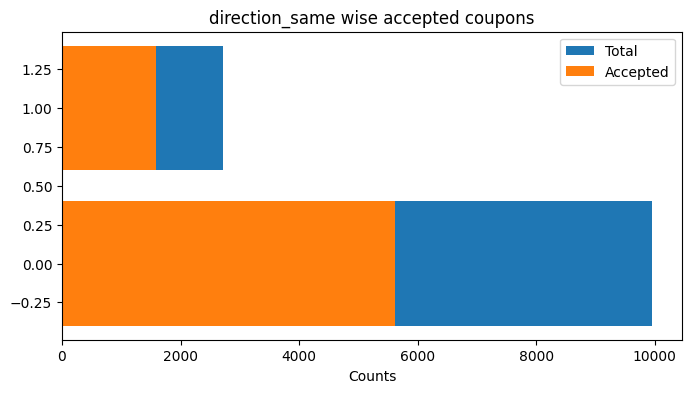

,direction_same,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,0,9960,78.524,5624,4336,56.466,43.534
1,1,2724,21.476,1586,1138,58.223,41.777


In [129]:
univariate_analysis(df,'direction_same')

Observations:

direction_same feature has 78% value is '0', and 22% value is '1'. Both value has almost similar acceptance ratio. so this feature not more usefull. So, we drop 'direction_same' feature.

In [130]:
df.drop(['direction_same'], axis=1, inplace=True)

B-coupon

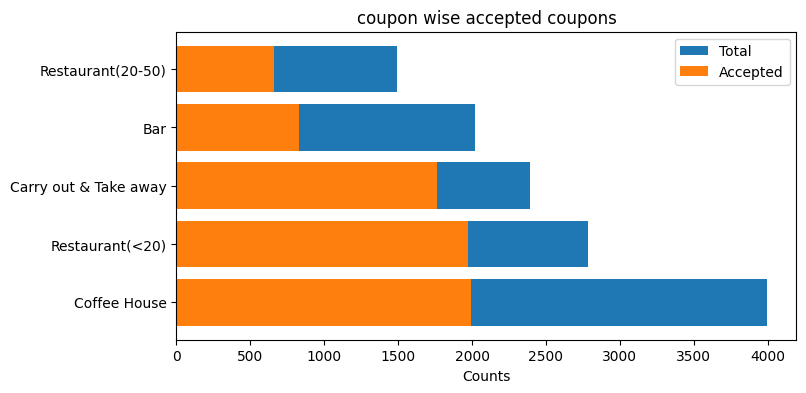

,coupon,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
2,Coffee House,3996,31.504,1995,2001,49.925,50.075
4,Restaurant(<20),2786,21.965,1970,816,70.711,29.289
1,Carry out & Take away,2393,18.866,1760,633,73.548,26.452
0,Bar,2017,15.902,827,1190,41.001,58.999
3,Restaurant(20-50),1492,11.763,658,834,44.102,55.898


In [131]:
univariate_analysis(df,'coupon')

Observations:


*Maximum coupons offered are for Coffee House coupons.

*Maximum coupons accepted by users are Carry out & Take away and Restaurant(<20) coupons.

*Bar coupon has a very low acceptance ratio.

C-Age

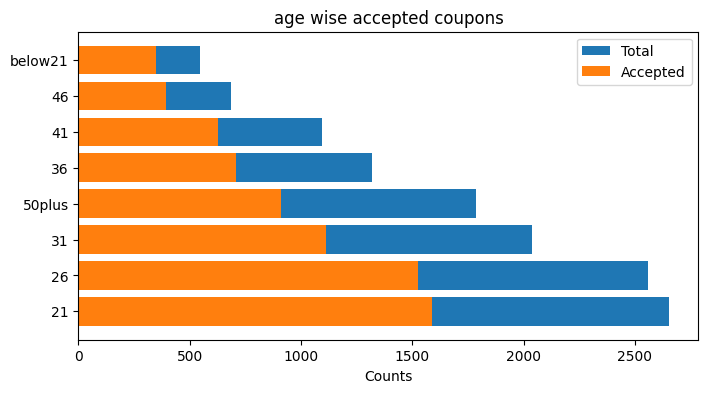

,age,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,21,2653,20.916,1587,1066,59.819,40.181
1,26,2559,20.175,1525,1034,59.594,40.406
2,31,2039,16.075,1114,925,54.635,45.365
6,50plus,1788,14.096,910,878,50.895,49.105
3,36,1319,10.399,706,613,53.525,46.475
4,41,1093,8.617,626,467,57.274,42.726
5,46,686,5.408,395,291,57.580,42.420
7,below21,547,4.313,347,200,63.437,36.563


In [132]:
univariate_analysis(df,'age')

Observations:

*Most users in this data have ages between 21 to 26 years.

*The users whose age is below 21 years have the highest coupon acceptance ratio.

*The users whose age is above 50 years have the highest coupon rejection ratio.

D- education

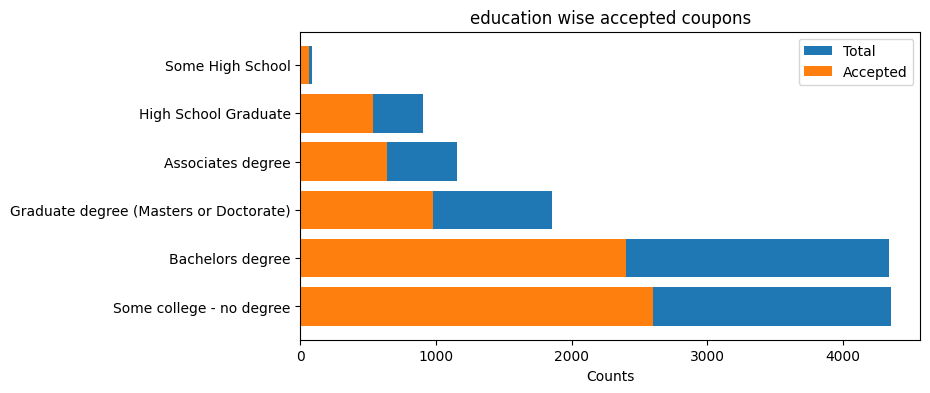

,education,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
5,Some college - no degree,4351,34.303,2595,1756,59.641,40.359
1,Bachelors degree,4335,34.177,2403,1932,55.433,44.567
2,Graduate degree (Masters or Doctorate),1852,14.601,975,877,52.646,47.354
0,Associates degree,1153,9.090,638,515,55.334,44.666
3,High School Graduate,905,7.135,536,369,59.227,40.773
4,Some High School,88,0.694,63,25,71.591,28.409


In [133]:
univariate_analysis(df,'education')

Observations:

*Most users have at least a Bachelor's degree or Some college - no degree.

*In this data, very few users have only Some High School education, and those users have the highest coupon acceptance ratio.

*Users who have a Graduate degree (Masters or Doctorate) have the least coupon acceptance ratio.

E-income

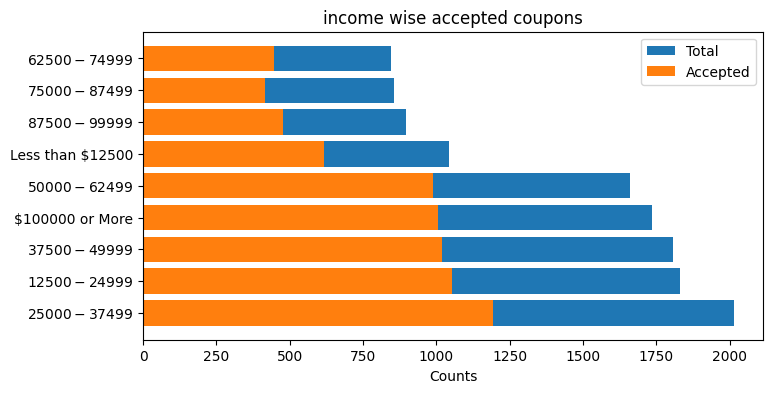

,income,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
2,$25000 - $37499,2013,15.870,1194,819,59.314,40.686
1,$12500 - $24999,1831,14.436,1052,779,57.455,42.545
3,$37500 - $49999,1805,14.231,1018,787,56.399,43.601
0,$100000 or More,1736,13.687,1004,732,57.834,42.166
4,$50000 - $62499,1659,13.079,988,671,59.554,40.446
8,Less than $12500,1042,8.215,618,424,59.309,40.691
7,$87500 - $99999,895,7.056,476,419,53.184,46.816
6,$75000 - $87499,857,6.757,414,443,48.308,51.692
5,$62500 - $74999,846,6.670,446,400,52.719,47.281


In [134]:
univariate_analysis(df,'income')

Observations:

*Most users in this data have income in between \$12500 and \$49999

*Users who have low income and high income accept more coupons than others.

*Users who have medium-range income are mostly rejecting the coupon.

F- destination

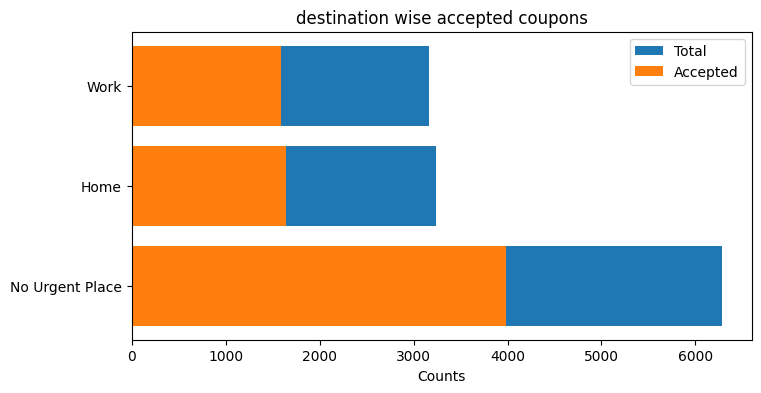

,destination,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
1,No Urgent Place,6283,49.535,3982,2301,63.377,36.623
0,Home,3237,25.520,1639,1598,50.633,49.367
2,Work,3164,24.945,1589,1575,50.221,49.779


In [135]:
univariate_analysis(df,'destination')

Observations:

*Most of the users go to No Urgent Place.

*The users who have destination No Urgent Place are accepting more coupons than others.

*The users who have destination Home and Work have almost similar coupon acceptance ratios.

G- passanger

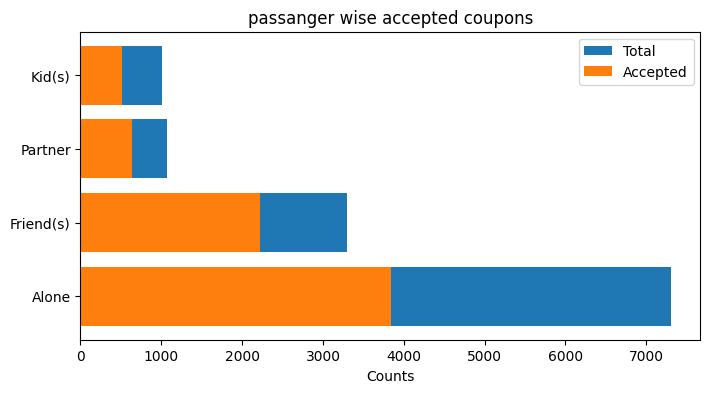

,passanger,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,Alone,7305,57.592,3841,3464,52.580,47.420
1,Friend(s),3298,26.001,2221,1077,67.344,32.656
3,Partner,1075,8.475,640,435,59.535,40.465
2,Kid(s),1006,7.931,508,498,50.497,49.503


In [136]:
univariate_analysis(df,'passanger')

Observations:

*Most of the time users go out Alone.

*The users who go out with Friends or Partner have more coupon acceptance ratios than Alone users.

*The users who go out with Friends are accepting more coupons than other co-passengers.

H-weather

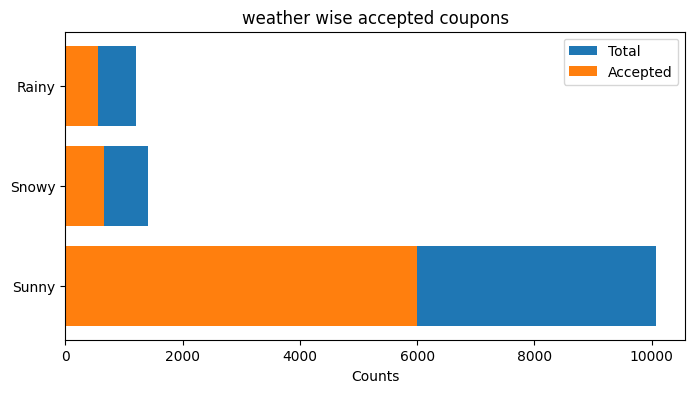

,weather,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
2,Sunny,10069,79.383,5989,4080,59.480,40.520
1,Snowy,1405,11.077,661,744,47.046,52.954
0,Rainy,1210,9.540,560,650,46.281,53.719


In [137]:
univariate_analysis(df,'weather')

Observations:

*In Sunny weather, users go out more and accept more coupons than other wethers.

I-temperature

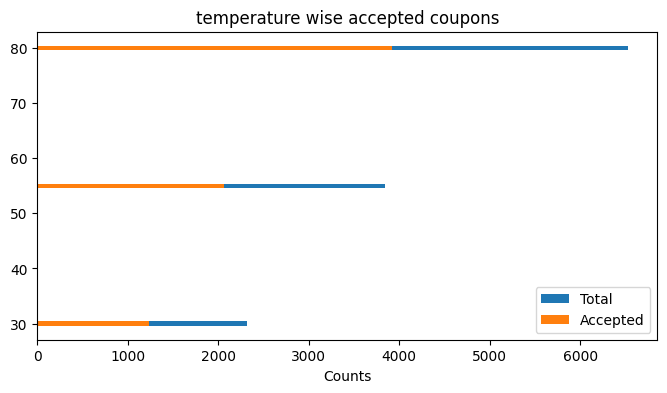

,temperature,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
2,80,6528,51.466,3919,2609,60.034,39.966
1,55,3840,30.274,2061,1779,53.672,46.328
0,30,2316,18.259,1230,1086,53.109,46.891


In [138]:
univariate_analysis(df,'temperature')

Observations:

*Most of the time users go out when the temperature is 80 F.

*When the temperature is 80 F, user's coupon acceptance ratio is approx 59.86%.rs.

J-time

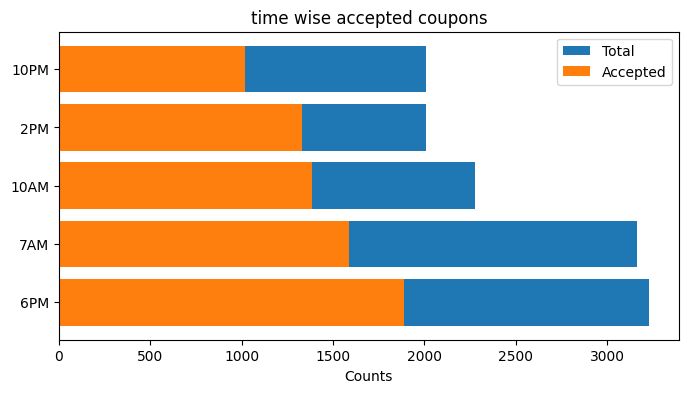

,time,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
3,6PM,3230,25.465,1888,1342,58.452,41.548
4,7AM,3164,24.945,1589,1575,50.221,49.779
0,10AM,2275,17.936,1384,891,60.835,39.165
2,2PM,2009,15.839,1329,680,66.152,33.848
1,10PM,2006,15.815,1020,986,50.847,49.153


In [139]:
univariate_analysis(df,'time')

Observations:

*Most of the time users go out when the time is 6 PM and 7 AM.

*The users mostly accept coupons when the time is 2 PM and 10 AM.

K-gender

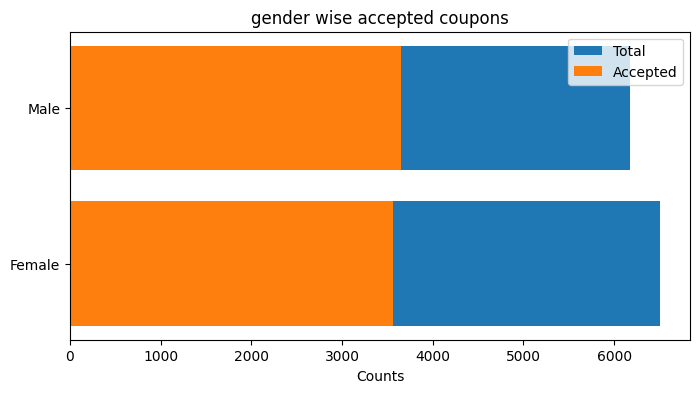

,gender,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,Female,6511,51.332,3563,2948,54.723,45.277
1,Male,6173,48.668,3647,2526,59.080,40.920


In [140]:
univariate_analysis(df,'gender')

Observations:

*Male and Female both have almost similar coupon acceptance ratios.

L- maritalStatus

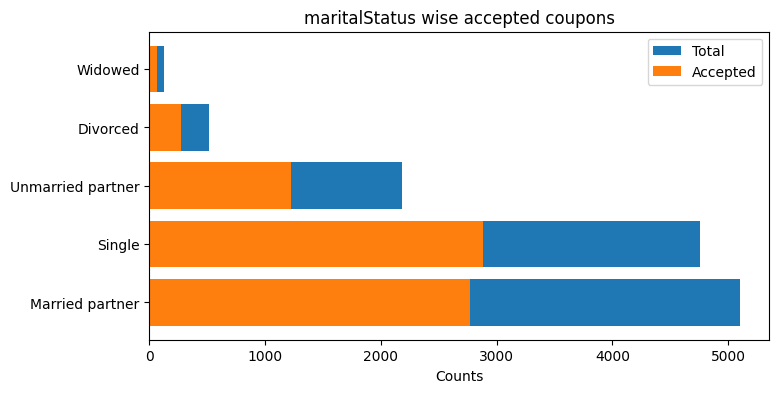

,maritalStatus,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
1,Married partner,5100,40.208,2769,2331,54.294,45.706
2,Single,4752,37.465,2879,1873,60.585,39.415
3,Unmarried partner,2186,17.234,1227,959,56.130,43.870
0,Divorced,516,4.068,273,243,52.907,47.093
4,Widowed,130,1.025,62,68,47.692,52.308


In [141]:
univariate_analysis(df,'maritalStatus')

Observations:

*Most users in this data are Single or have Married partner.

*Single users accept more coupons than others.

*Bivariate Analysis*

Q - What time do users go to Work, Home, or No Urgent Place, and with whom?

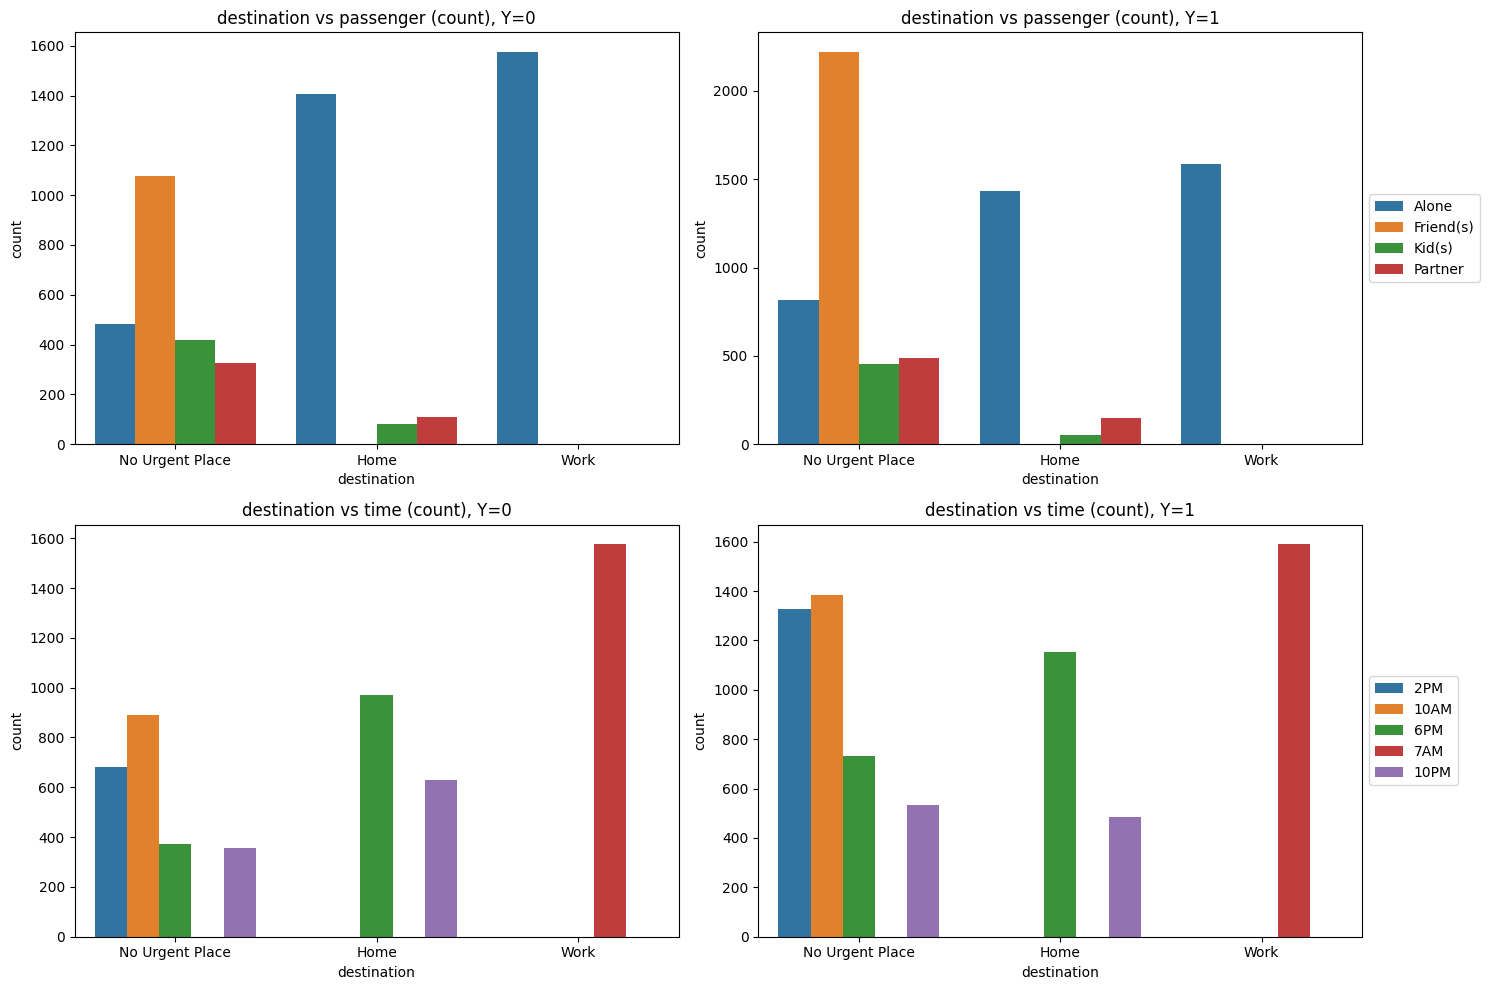

In [142]:
# Define the order of unique values for each variable
destination_order = df['destination'].unique()
passenger_order = df['passanger'].unique()
time_order = df['time'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for 'destination' vs 'passenger', Y=0
sns.countplot(x='destination', hue='passanger', data=df[df['Y'] == 0], ax=axes[0, 0], order=destination_order, hue_order=passenger_order)
axes[0, 0].set_title('destination vs passenger (count), Y=0')
axes[0, 0].legend().remove()

# Plot for 'destination' vs 'passenger', Y=1
sns.countplot(x='destination', hue='passanger', data=df[df['Y'] == 1], ax=axes[0, 1], order=destination_order, hue_order=passenger_order)
axes[0, 1].set_title('destination vs passenger (count), Y=1')

# Set legend on the right
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for 'destination' vs 'time', Y=0
sns.countplot(x='destination', hue='time', data=df[df['Y'] == 0], ax=axes[1, 0], order=destination_order, hue_order=time_order)
axes[1, 0].set_title('destination vs time (count), Y=0')
axes[1, 0].legend().remove()

# Plot for 'destination' vs 'time', Y=1
sns.countplot(x='destination', hue='time', data=df[df['Y'] == 1], ax=axes[1, 1], order=destination_order, hue_order=time_order)
axes[1, 1].set_title('destination vs time (count), Y=1')

# Set legend on the right
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

Observations:

*The users who go with Friends have only No Urgent Place destination.

*Maximum users accept coupons when the time is 2 PM and 10 AM, the destination is No Urgent Place, and the co-passanger is Friends.

*The users who have destination Home and Work have almost similar coupon acceptance ratios.

Q - At what time, which coupon acceptance ratio is high?

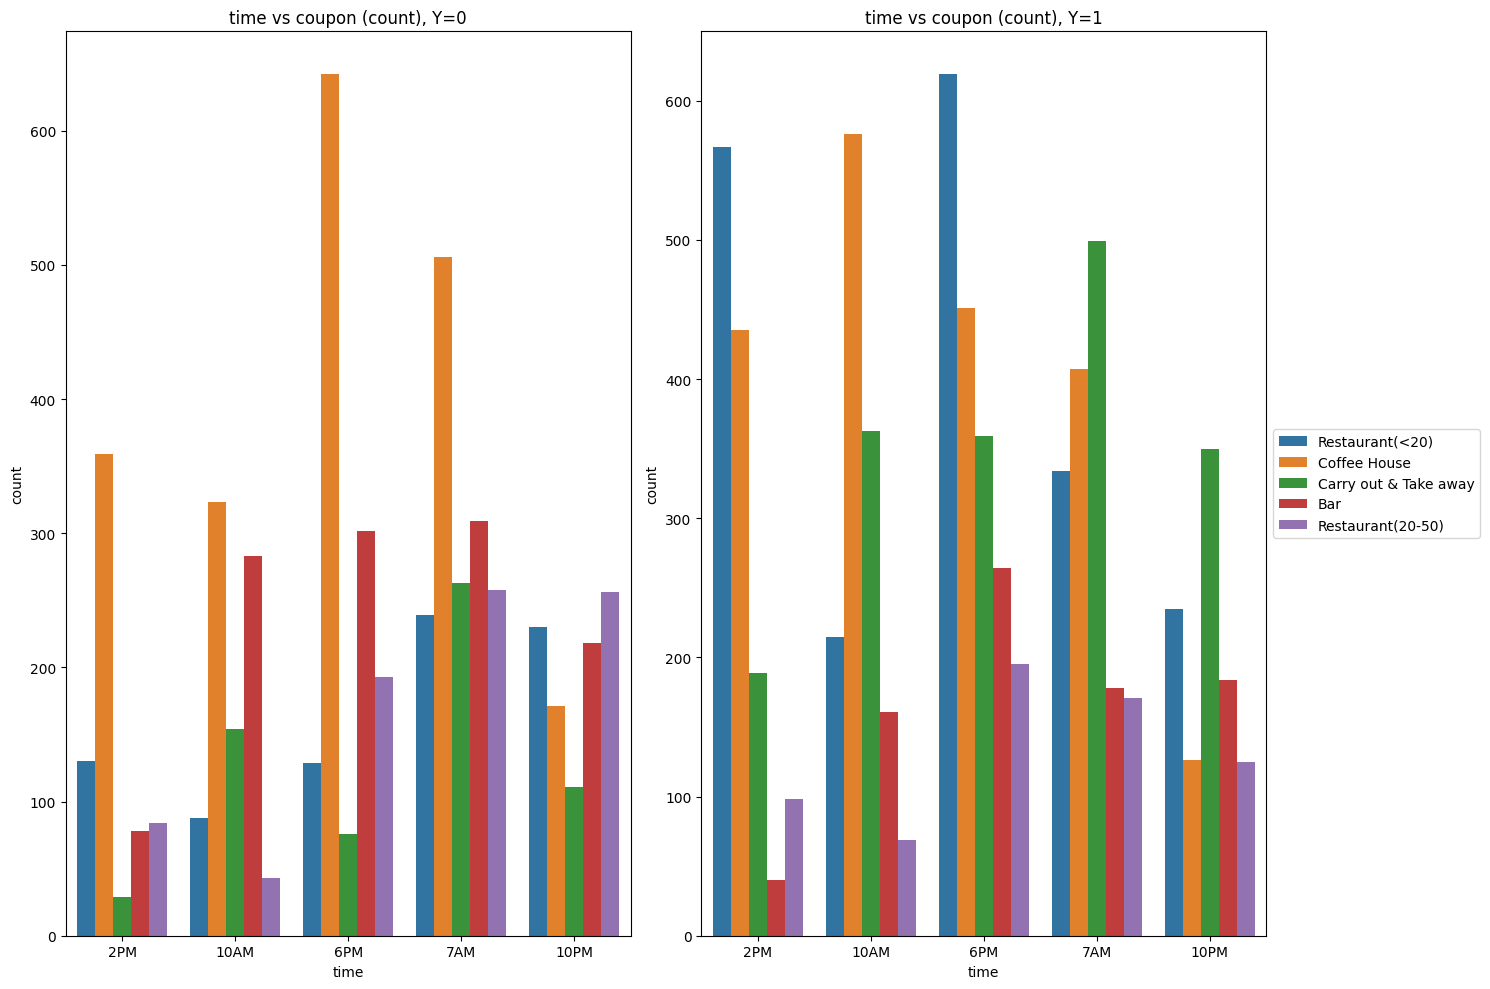

In [143]:
# Define the order of unique values for each variable
coupon_order = df['coupon'].unique()
time_order = df['time'].unique()

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot for 'destination' vs 'passenger', Y=0
sns.countplot(x='time', hue='coupon', data=df[df['Y'] == 0], ax=axes[0], order=time_order, hue_order=coupon_order)
axes[0].set_title('time vs coupon (count), Y=0')
axes[0].legend().remove()

# Plot for 'destination' vs 'passenger', Y=1
sns.countplot(x='time', hue='coupon', data=df[df['Y'] == 1], ax=axes[1], order=time_order, hue_order=coupon_order)
axes[1].set_title('time vs coupon (count), Y=1')

# Set legend on the right
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
plt.show()

Observations:

*At 10AM, 2 PM and 6 PM, users mostly accept Restaurant(<20), Carry out and coffee house coupons.

*At 7 AM, 10AM, 2PM and 6 PM, Coffee House coupon ask is maximum.

*At 10 PM, mostly Carry out & Take away and Restaurant(<20) coupons are accepted, and Restaurant(20–50) coupons are rejected.

*Users mostly reject coupons for Bar at 7 AM, 10 AM, and 2 PM.

###7.FEATURE ENGINEERING###

In [144]:
df.dtypes

,0
destination,object
passanger,object
weather,object
temperature,int64
time,object
coupon,object
expiration,object
gender,object
age,object
maritalStatus,object


In [145]:
# Identify categorical columns in the dataset
categorical_columns = df.select_dtypes(include=['object']).columns

# Display the identified categorical columns
categorical_columns.tolist()

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'time_24hr']

In [147]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

#   One-Hot Encoding
one_hot_encoded_data = pd.get_dummies(df, columns=['gender', 'weather','destination','passanger','time','coupon','expiration','age','maritalStatus','education','occupation','income','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','time_24hr'], drop_first=True)


print(one_hot_encoded_data.head())


   temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
0           55             1                 1                  0   
1           80             1                 1                  0   
2           80             1                 1                  1   
3           80             1                 1                  1   
4           80             1                 1                  1   

   toCoupon_GEQ25min  direction_opp  Y  expiration_hours  gender_Male  \
0                  0              1  1                24        False   
1                  0              1  0                 2        False   
2                  0              1  1                 2        False   
3                  0              1  0                 2        False   
4                  0              1  0                24        False   

   weather_Snowy  ...  RestaurantLessThan20_never  Restaurant20To50_4~8  \
0          False  ...                       False                 False

###8.SPLIT DATA INTO TRAINING AND TESTING SETS

In [151]:
from sklearn.model_selection import train_test_split

# separating our independent and dependent variable
X = df.drop(['Y'], axis = 1)
y = df["Y"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20, random_state=0)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (10147, 25)
Testing Set Shape: (2537, 25)


###9.FEATURE SELECTION###

RANDOM FOREST CLASSIFIER

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target variable
X = df.drop(columns=['Y'])  # Replace 'Y' with your target column
y = df['Y']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_encoded, y)
feature_importances = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

# Convert feature importances to a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_importances.index, 'Importance': feature_importances.values})


print("Top Features by Random Forest:\n", feature_importance_df.head(18))


Top Features by Random Forest:
                                Feature  Importance
0         coupon_Carry out & Take away    0.030176
1               coupon_Restaurant(<20)    0.029548
2                  coupon_Coffee House    0.027751
3                          temperature    0.027141
4                    CoffeeHouse_never    0.024641
5                    toCoupon_GEQ15min    0.022654
6                          gender_Male    0.019390
7               Restaurant20To50_less1    0.019354
8                        CarryAway_4~8    0.018153
9                            Bar_never    0.018150
10                       expiration_2h    0.017125
11            RestaurantLessThan20_4~8    0.016802
12                   CoffeeHouse_less1    0.016332
13          education_Bachelors degree    0.016285
14                 passanger_Friend(s)    0.015899
15                        has_children    0.015846
16  education_Some college - no degree    0.015820
17                    expiration_hours    0.015511

In [155]:
# Set a threshold for removing features
threshold = 0.02
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

In [156]:
# Filter the dataset to include only the important features
X_selected = X_encoded[important_features]

In [157]:
# Display the selected features
print("\nSelected Features after Removing Irrelevant/Redundant Features:")
print(X_selected)


Selected Features after Removing Irrelevant/Redundant Features:
       coupon_Carry out & Take away  coupon_Restaurant(<20)  \
0                             False                    True   
1                             False                   False   
2                              True                   False   
3                             False                   False   
4                             False                   False   
...                             ...                     ...   
12679                          True                   False   
12680                          True                   False   
12681                         False                   False   
12682                         False                   False   
12683                         False                   False   

       coupon_Coffee House  temperature  CoffeeHouse_never  toCoupon_GEQ15min  
0                    False           55               True                  0  
1                 

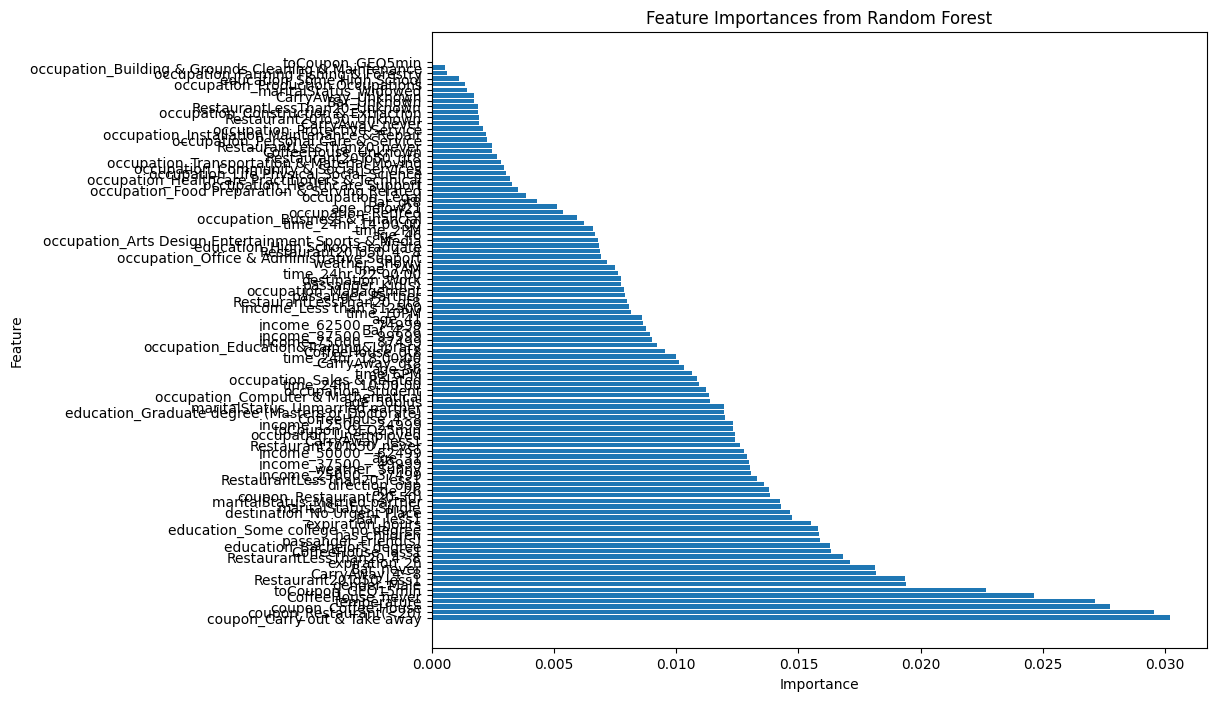

In [158]:
# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show()

###10.FEATURE SCALING###

In [206]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20, random_state=0)

#   Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train_encoded )
X_test_scaled = min_max_scaler.transform(X_test_encoded)

print("Scaled Training Data:\n", X_train_scaled[:10])

Scaled Training Data:
 [[1.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.
  0.   1.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.5  0.   0.   0.   0.   1.   0.25 0.   1.   0.   0.   0.   0.   1.
  0.   0.   0.   1.   0.   0.   0.   1.   0.   1.   0.   0.   0.   1.
  0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 

###11.MODEL BUILDING

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [208]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [209]:
# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

In [210]:
#Make predictions
y_pred = model.predict(X_test_scaled)

###12.MODEL EVALUATION

In [211]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

*Logistic Regression*

In [212]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [213]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

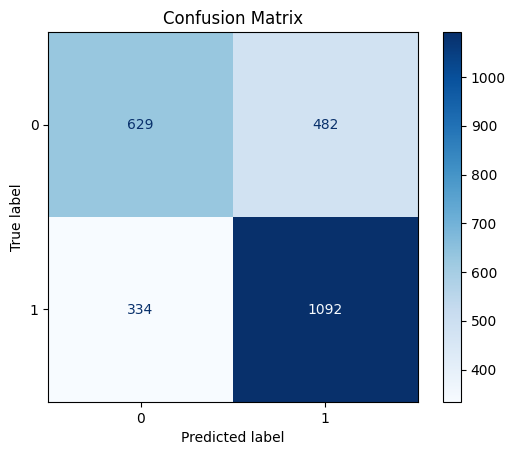

In [214]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [215]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.67      0.67      0.67      2537
weighted avg       0.68      0.68      0.67      2537



In [216]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

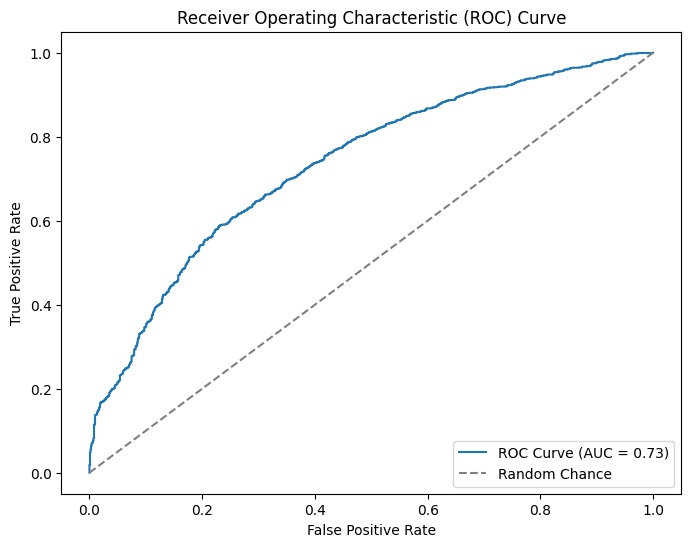

In [217]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

SVM

In [218]:
model = SVC(probability=True)
model.fit(X_train_scaled, y_train)

SVC(probability=True)

In [219]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

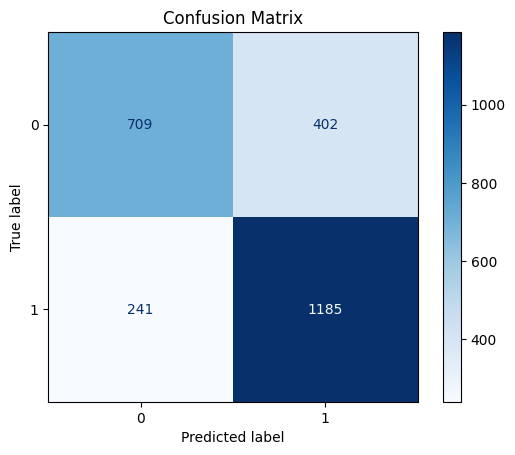

In [220]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [221]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69      1111
           1       0.75      0.83      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.73      0.74      2537
weighted avg       0.75      0.75      0.74      2537



In [222]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

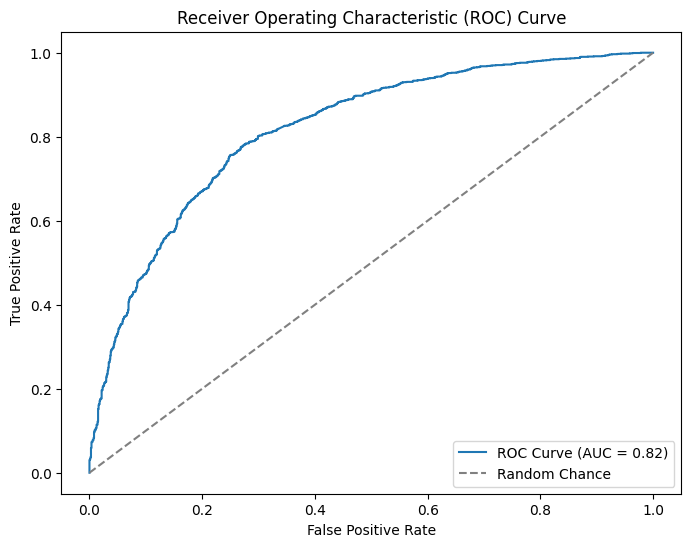

In [223]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

*Decision Tree*

In [224]:
model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [225]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

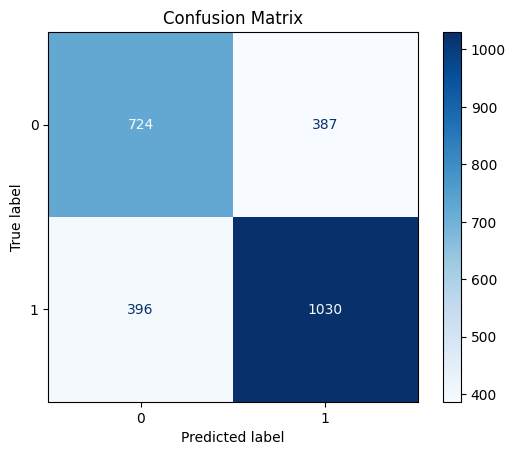

In [226]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [227]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65      1111
           1       0.73      0.72      0.72      1426

    accuracy                           0.69      2537
   macro avg       0.69      0.69      0.69      2537
weighted avg       0.69      0.69      0.69      2537



In [228]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

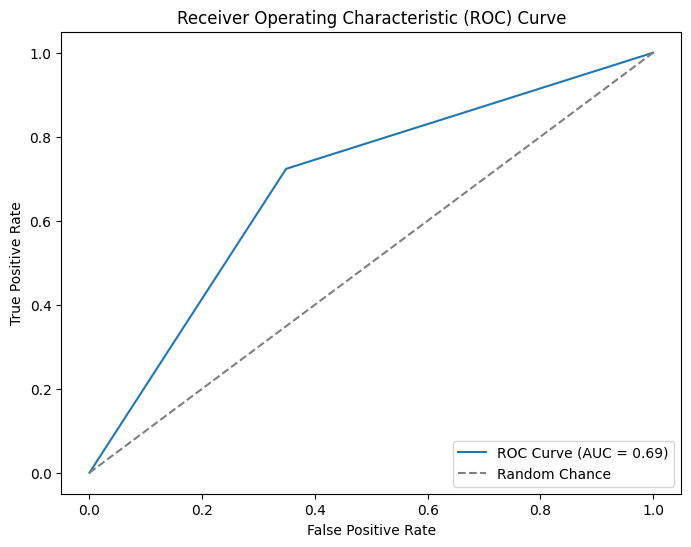

In [229]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

*Random Forest*

In [230]:
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [231]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

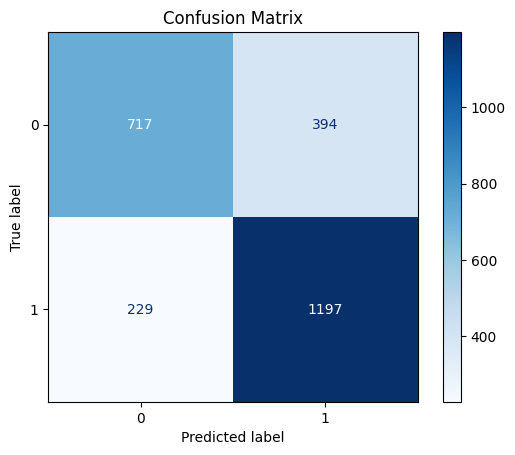

In [232]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [233]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70      1111
           1       0.75      0.84      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.76      0.74      0.75      2537
weighted avg       0.75      0.75      0.75      2537



In [234]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

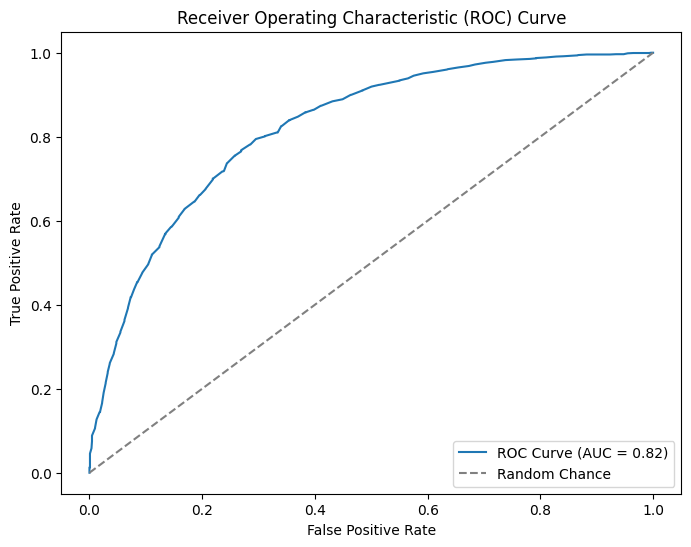

In [235]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

*K-Nearest Neighbors*

In [236]:
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [237]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

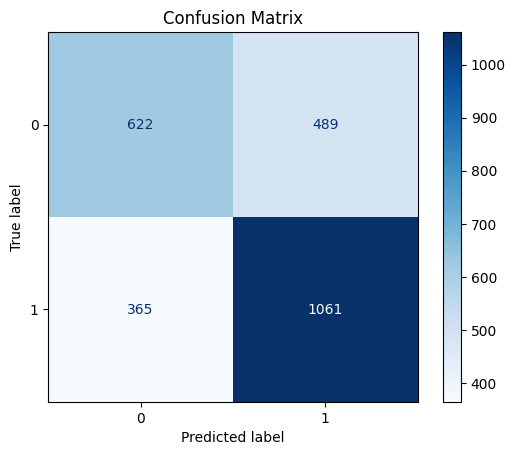

In [238]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [239]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.59      1111
           1       0.68      0.74      0.71      1426

    accuracy                           0.66      2537
   macro avg       0.66      0.65      0.65      2537
weighted avg       0.66      0.66      0.66      2537



In [240]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

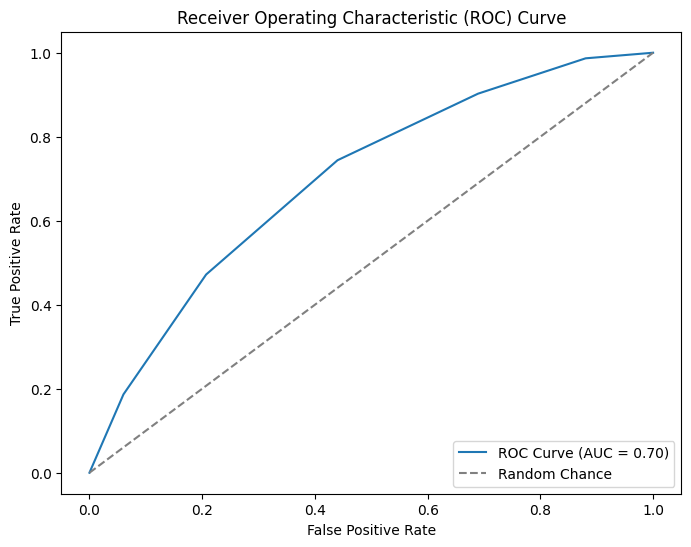

In [241]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

*Gradient booster*

In [242]:
model = GradientBoostingClassifier()
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [243]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

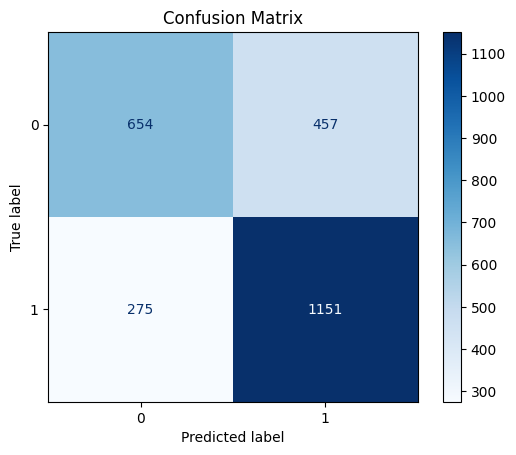

In [244]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [245]:
# 2. Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.59      0.64      1111
           1       0.72      0.81      0.76      1426

    accuracy                           0.71      2537
   macro avg       0.71      0.70      0.70      2537
weighted avg       0.71      0.71      0.71      2537



In [246]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

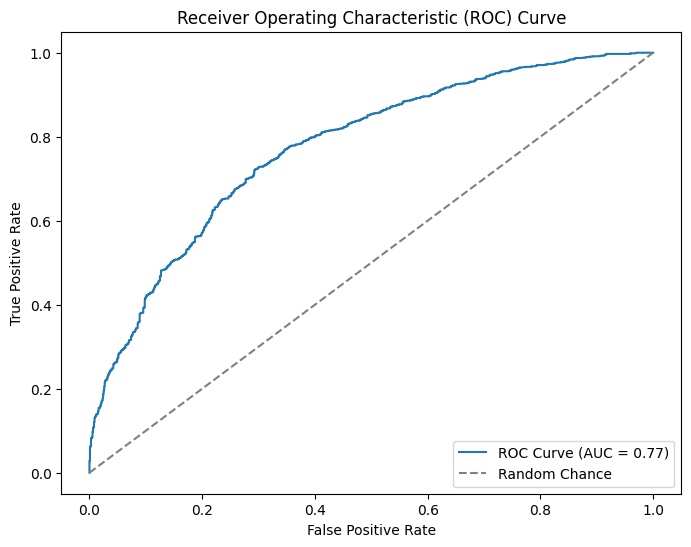

In [247]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

*classification report*

In [248]:
for name, model in models.items():
    print(f"Training model: {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Generate the classification report
    print(f"Classification Report for {name}:\n")
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)
    print("-" * 50)  # Separator for better readability

Training model: Logistic Regression...
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

     Class 0       0.65      0.57      0.61      1111
     Class 1       0.69      0.77      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.67      0.67      0.67      2537
weighted avg       0.68      0.68      0.67      2537

--------------------------------------------------
Training model: SVM...
Classification Report for SVM:

              precision    recall  f1-score   support

     Class 0       0.75      0.64      0.69      1111
     Class 1       0.75      0.83      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.73      0.74      2537
weighted avg       0.75      0.75      0.74      2537

--------------------------------------------------
Training model: Decision Tree...
Classification Report for Decision Tree:

              precision    

##BEST MODEL

In [249]:
# Dictionary to store model accuracies
model_accuracies = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    model_accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")

# Find the best model based on accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]

print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_accuracy:.2f}")

Logistic Regression Accuracy: 0.68
SVM Accuracy: 0.75
Decision Tree Accuracy: 0.69
Random Forest Accuracy: 0.76
K-Nearest Neighbors Accuracy: 0.66
Gradient Boosting Accuracy: 0.71

Best Model: Random Forest with Accuracy: 0.76


###13.HYPERPARAMETER TUNING

In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [251]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

In [252]:
# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf,
                                    param_distributions=param_grid,
                                    n_iter=100,  # Number of random combinations to try
                                    scoring='accuracy',
                                    cv=5,  # 5-fold cross-validation
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1)  # Use all available processors

In [253]:
# Fit the model
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   random_state=42, scoring='accuracy', verbose=2)

In [254]:
# Evaluate the best model on test data
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

In [255]:
# Print classification metrics
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7607410327158061

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71      1111
           1       0.76      0.84      0.80      1426

    accuracy                           0.76      2537
   macro avg       0.76      0.75      0.75      2537
weighted avg       0.76      0.76      0.76      2537



###14.SAVE THE MODEL

In [277]:
import joblib

# Save the best Random Forest model
joblib.dump(best_rf, 'in-vehicle_coupon_recommendation.pkl')
print("Model saved successfully as 'in-vehicle_coupon_recommendation.pkl'")


Model saved successfully as 'in-vehicle_coupon_recommendation.pkl'


In [278]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler # import missing module
# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  # Scaling step
    ('model', best_rf)
     ])
# add closing parenthesis

# Fit the pipeline on training data
pipeline.fit(X_train_scaled, y_train)


# Fit the pipeline on training data
pipeline.fit(X_train_scaled, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_features=None, min_samples_leaf=2,
                                        n_estimators=500, random_state=42))])

In [279]:

# Save the entire pipeline
joblib.dump(pipeline, 'in-vehicle_coupon_recommendation.pkl')
print("Pipeline saved successfully as 'in-vehicle_coupon_recommendation.pkl'")


Pipeline saved successfully as 'in-vehicle_coupon_recommendation.pkl'


###15.TEST WITH UNSEEN DATA

In [293]:
# Load the saved pipeline
loaded_pipeline = joblib.load('in-vehicle_coupon_recommendation.pkl')
print("in-vehicle_coupon_recommendation!")

in-vehicle_coupon_recommendation!


In [294]:
# Make predictions using the unseen data
# Preprocess the unseen data using the same preprocessing steps as during training
X_unseen_encoded = pd.get_dummies(X_unseen, drop_first=True)  # One-hot encoding

# Get missing columns in `X_unseen_encoded`
missing_cols = set(X_train_encoded.columns) - set(X_unseen_encoded.columns)
# Add a missing column in `X_unseen_encoded`
for c in missing_cols:
    X_unseen_encoded[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_unseen_encoded = X_unseen_encoded[X_train_encoded.columns]


X_unseen_scaled = min_max_scaler.transform(X_unseen_encoded)  # Scaling

predictions_unseen = loaded_pipeline.predict(X_unseen_scaled)



###16.CONCLUSION

MODEL PERFORMANCE ANALYSIS


#Training Data Performance:

###1.Precision, Recall, and F1-Score:
   
*Class 0: Precision = 0.76, Recall = 0.66, F1-Score = 0.71

*Class 1: Precision = 0.76, Recall = 0.84, F1-Score = 0.80

*The model shows better recall for Class 1 compared to Class 0, suggesting it identifies positive instances (Class 1) more effectively but struggles slightly with negative instances (Class 0).

*The F1-scores are reasonably balanced but indicate room for improvement, particularly in detecting Class 0.

###2.Overall Accuracy: 0.76
Indicates the model performs well but not exceptionally, with an accuracy of 76% on the training data.

###3.Macro Average & Weighted Average:

*Macro averages for precision, recall, and F1-score are all around 0.75, reflecting balanced but moderate performance for both classes.

*Weighted averages are identical to overall performance due to class distribution being considered.

##Conclusion:
1.Training Data Observations:

The model performs moderately well on the training data, with some challenges in identifying Class 0 instances (lower recall for Class 0).
This indicates the potential for some misclassification or imbalance in the dataset affecting the training performance.



2.Limitations of the Dataset:

*Class Imbalance: The support values indicate that Class 1 (positive) has slightly more samples (1426 vs. 1111) in the training dataset. This imbalance could explain why the model performs better on Class 1.

*Potential Noise: The gap between training and test performance might indicate noise or outliers in the training dataset that the model struggles with, impacting its recall for Class 0.

*Dataset Size: While the total number of samples (2537 training, 2030 test) is reasonable, a larger dataset could further stabilize and improve performance metrics, especially for less represented or harder-to-classify instances.


###17.FUTURE WORK

This machine learning model is designed to predict whether a customer will accept an in-vehicle coupon based on various contextual, demographic, and behavioral features. Here are the potential use cases and applications:

1.Personalized Marketing Strategies

Purpose: Deliver personalized coupon offers to customers in real time.

Application:Tailor discounts or promotions based on customer preferences and contextual data (e.g., time of day, weather). Increase the likelihood of coupon acceptance by targeting customers who are more likely to redeem offers.

-

2.Enhancing Customer Engagement

Purpose: Build a stronger relationship with customers by offering relevant deals.

Application:Provide value-added services during drives, such as exclusive coupons for nearby restaurants or retail stores. Boost customer satisfaction and loyalty by ensuring offers are aligned with their interests and behavior.

-

3.Revenue Optimization for Businesses

Purpose: Maximize the efficiency and ROI of coupon campaigns.

Application:Reduce costs associated with wasted coupons by targeting customers with a higher probability of acceptance. Drive foot traffic to businesses by offering location-specific coupons for nearby stores or attractions.

-

4.Integration with Ride-Sharing and Navigation Systems

Purpose: Enhance the in-vehicle experience with context-aware recommendations.

Application:Embed the model into ride-sharing apps like Uber or Lyft to offer passengers deals at their destination or along their route. Integrate with navigation systems (e.g., Google Maps) to recommend coupons for stores/restaurants near planned stops.



---

